In [1]:
import tensorflow as tf

import IPython.display as display

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12,12)
mpl.rcParams['axes.grid'] = False

import numpy as np
import PIL.Image
import time
import functools

In [2]:
def tensor_to_image(tensor):
    tensor = tensor * 255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor) > 3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]
    return PIL.Image.fromarray(tensor)


def load_img(img_path):
    max_dim = 512
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)

    shape = tf.cast(tf.shape(img)[:-1], tf.float32)
    long_dim = max(shape)
    scale = max_dim / long_dim

    new_shape = tf.cast(shape * scale, tf.int32)
    img = tf.image.resize(img, new_shape)
    img = img[tf.newaxis, :] # add an axis
    return img


def imshow(image, title=None):
    if len(image.shape) > 3:
        image = tf.squeeze(image, axis=0)

    plt.imshow(image)
    if title:
        plt.title(title)


content image size:  (1, 384, 512, 3)
style image size：  (1, 430, 512, 3)


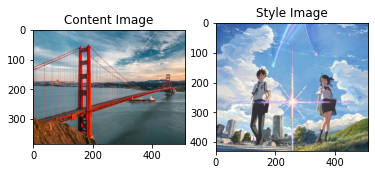

In [3]:
'''
content_path = tf.keras.utils.get_file('YellowLabradorLooking_new.jpg', 'https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg')
style_path = tf.keras.utils.get_file('kandinsky5.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg')
'''

content_path = '/content/drive/MyDrive/style_transfer/content/golden_gate_bridge.jpg'
style_path = '/content/drive/MyDrive/style_transfer/style/your_name_2.jpg'

content_img = load_img(content_path)
style_img = load_img(style_path)

print('content image size: ', content_img.shape)
print('style image size： ', style_img.shape)

plt.subplot(1, 2, 1)
imshow(content_img, 'Content Image')

plt.subplot(1, 2, 2)
imshow(style_img, 'Style Image')

Load VGG19 model and test it.

In [4]:
from tensorflow.keras.applications import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input

x = preprocess_input(content_img * 255)
x = tf.image.resize(x, (224, 224))
vgg = VGG19(include_top=True, weights='imagenet')
prediction_probabilities = vgg(x)
prediction_probabilities.shape

TensorShape([1, 1000])

In [5]:
from tensorflow.keras.applications.vgg19 import decode_predictions

predicted_top_5 = decode_predictions(prediction_probabilities.numpy())[0]
[(class_name, prob) for (number, class_name, prob) in predicted_top_5]

[('pier', 0.33158964),
 ('suspension_bridge', 0.32492408),
 ('promontory', 0.22461826),
 ('container_ship', 0.06380446),
 ('crane', 0.010116399)]

Load VGG19 model without classification part.

In [6]:
vgg = VGG19(include_top=False, weights='imagenet')

print()
for layer in vgg.layers:
    print(layer.name)


input_2
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


In [7]:
content_layers = ['block5_conv2'] 
style_layers = [
    'block1_conv1',
    'block2_conv1',
    'block3_conv1', 
    'block4_conv1', 
    'block5_conv1',
]

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

The networks in [tf.keras.applications](https://tensorflow.google.cn/api_docs/python/tf/keras/applications) are designed so you can easily extract the intermediate layer values using the Keras functional API.

To define a model using the functional API, specify the inputs and outputs:
```
model = Model(inputs, outputs)
```
This following function builds a VGG19 model that returns a list of intermediate layer outputs:

In [8]:
def vgg_layers(layer_names):
    vgg = VGG19(include_top=False, weights='imagenet')
    vgg.trainable = False
    
    outputs = [vgg.get_layer(name).output for name in layer_names]
    
    model = tf.keras.Model([vgg.input], outputs)
    return model

In [9]:
style_extractor = vgg_layers(style_layers)
style_outputs = style_extractor(style_img * 255)

# Look at the statistics of each layer's output
for name, output in zip(style_layers, style_outputs):
    print(name)
    print("\tshape:\t", output.numpy().shape)
    print("\tmin:\t", output.numpy().min())
    print("\tmax:\t", output.numpy().max())
    print("\tmean:\t", output.numpy().mean())
    print()

block1_conv1
	shape:	 (1, 430, 512, 64)
	min:	 0.0
	max:	 844.012
	mean:	 28.44792

block2_conv1
	shape:	 (1, 215, 256, 128)
	min:	 0.0
	max:	 3428.0544
	mean:	 160.95404

block3_conv1
	shape:	 (1, 107, 128, 256)
	min:	 0.0
	max:	 7448.55
	mean:	 143.65218

block4_conv1
	shape:	 (1, 53, 64, 512)
	min:	 0.0
	max:	 14516.38
	mean:	 601.6413

block5_conv1
	shape:	 (1, 26, 32, 512)
	min:	 0.0
	max:	 3889.9648
	mean:	 50.937744



In [10]:
def gram_matrix(input_tensor):
    result = tf.linalg.einsum(
        'bijc,bijd->bcd', input_tensor, input_tensor
    )
    input_shape = tf.shape(input_tensor)
    num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
    return result/(num_locations)


In [11]:
class StyleContentModel(tf.keras.models.Model):
    def __init__(self, style_layers, content_layers):
        super(StyleContentModel, self).__init__()
        self.vgg = vgg_layers(style_layers + content_layers)
        self.content_layers = content_layers
        self.style_layers = style_layers
        self.num_content_layers = len(content_layers)
        self.num_style_layers = len(style_layers)
        self.vgg.trainable = False
    
    def call(self, inputs):
        "Expect float input in [0,1]"
        inputs = inputs * 255
        preprocessed_inputs = preprocess_input(inputs)
        outputs = self.vgg(preprocessed_inputs)
        
        content_outputs = outputs[self.num_style_layers:]
        style_outputs = outputs[:self.num_style_layers]
        style_outputs = [
            gram_matrix(style_output) 
            for style_output in style_outputs
        ]

        content_dict = {
            content_name:value for content_name, value 
            in zip(self.content_layers, content_outputs)
        }
        style_dict = {
            style_name:value for style_name, value
            in zip(self.style_layers, style_outputs)
        }

        return {'content':content_dict, 'style':style_dict}


In [12]:
extractor = StyleContentModel(style_layers, content_layers)

results = extractor(tf.constant(content_img))

print('Styles:')
for name, output in sorted(results['style'].items()):
    print("\t", name)
    print("\t\tshape:\t", output.numpy().shape)
    print("\t\tmin:\t", output.numpy().min())
    print("\t\tmax:\t", output.numpy().max())
    print("\t\tmean:\t", output.numpy().mean())
    print()

print("Contents:")
for name, output in sorted(results['content'].items()):
    print("\t", name)
    print("\t\tshape:\t", output.numpy().shape)
    print("\t\tmin:\t", output.numpy().min())
    print("\t\tmax:\t", output.numpy().max())
    print("\t\tmean:\t", output.numpy().mean())

Styles:
	 block1_conv1
		shape:	 (1, 64, 64)
		min:	 0.015833344
		max:	 19555.068
		mean:	 474.78662

	 block2_conv1
		shape:	 (1, 128, 128)
		min:	 0.0
		max:	 214106.64
		mean:	 12688.911

	 block3_conv1
		shape:	 (1, 256, 256)
		min:	 0.38788024
		max:	 862598.44
		mean:	 19475.312

	 block4_conv1
		shape:	 (1, 512, 512)
		min:	 0.0
		max:	 6950274.0
		mean:	 237972.81

	 block5_conv1
		shape:	 (1, 512, 512)
		min:	 0.0
		max:	 92103.43
		mean:	 1942.7653

Contents:
	 block5_conv2
		shape:	 (1, 24, 32, 512)
		min:	 0.0
		max:	 1096.3721
		mean:	 15.941567


In [13]:
style_targets = extractor(style_img)['style']
content_targets = extractor(content_img)['content']

In [14]:
img = tf.Variable(content_img)
#img = tf.Variable(np.zeros_like(content_img))

def clip_0_1(img):
    return tf.clip_by_value(img, clip_value_min=0.0, clip_value_max=1.0)

opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

style_weight=1e-2
content_weight=1e4

def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2) 
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) 
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss

In [15]:
@tf.function()
def train_step(img):
    with tf.GradientTape() as tape:
        outputs = extractor(img)
        loss = style_content_loss(outputs)
    
    grad = tape.gradient(loss, img)
    opt.apply_gradients([(grad, img)])
    img.assign(clip_0_1(img))

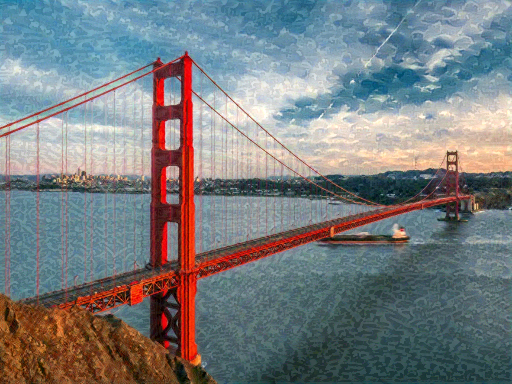

In [16]:
train_step(img)
train_step(img)
train_step(img)
tensor_to_image(img)

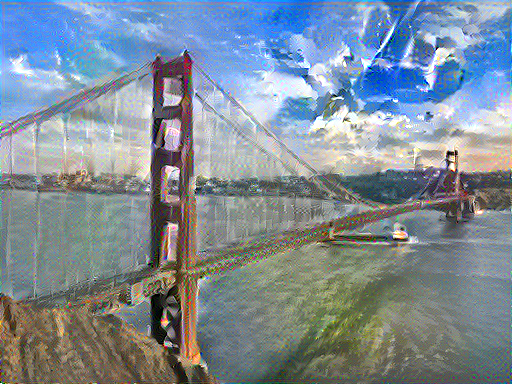

Train step: 1000
Total time: 75.8


In [17]:
import time
start = time.time()

epochs = 10
steps_per_epoch = 100

step = 0
for n in range(epochs):
    for m in range(steps_per_epoch):
        step += 1
        train_step(img)
        print(".", end='')
    display.clear_output(wait=True)
    display.display(tensor_to_image(img))
    print("Train step: {}".format(step))

end = time.time()
print("Total time: {:.1f}".format(end-start))

In [18]:
def total_loss(outputs, content_weight=1e4, tyle_weight=1e-2, total_variation_weight=30):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2) 
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) 
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss + total_variation_weight * tf.image.total_variation(img)
    return loss

In [19]:
@tf.function()
def train_step(img):
    with tf.GradientTape() as tape:
        outputs = extractor(img)
        loss = total_loss(outputs)
    grad = tape.gradient(loss, img)
    opt.apply_gradients([(grad, img)])
    img.assign(clip_0_1(img))

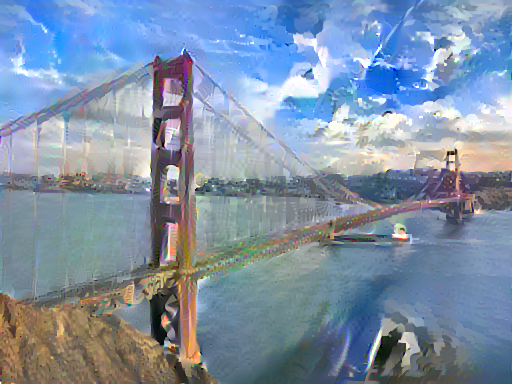

Train step: 1000
Total time: 77.6


In [20]:
img = tf.Variable(content_img)

start = time.time()

epochs = 10
steps_per_epoch = 100

step = 0
for n in range(epochs):
    for m in range(steps_per_epoch):
        step += 1
        train_step(img)
        print(".", end='')
    display.clear_output(wait=True)
    display.display(tensor_to_image(img))
    print("Train step: {}".format(step))

end = time.time()
print("Total time: {:.1f}".format(end-start))